# 2D Nuclear Segmentation with Mask-RCNN

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# create folder for this set of experiments
experiment_folder = "retina_mask"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/20201018_freeze/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [8]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20201018_multiplex_seed_2_"

train_dict = np.load(NPZ_DIR + npz_name + "train_512x512.npz", allow_pickle=True)
val_dict = np.load(NPZ_DIR + npz_name + "val_256x256.npz", allow_pickle=True)

In [9]:
from deepcell_toolbox.multiplex_utils import multiplex_preprocess
X_train, y_train = train_dict['X'], train_dict['y']
# X_val, y_val = val_dict['X'], val_dict['y']

In [10]:
X_train = multiplex_preprocess(X_train)

In [11]:
keep_index = np.random.choice(range(X_train.shape[0]), 500, False)

In [6]:
np.savez_compressed(NPZ_DIR + npz_name + 'train_128x128.npz', 
                    X=X_train[:, :128, :128, :], y=y_train[:, :128, :128, :])

In [7]:
np.savez_compressed(NPZ_DIR + npz_name + 'train_512x512_500.npz', 
                    X=X_train[:500], y=y_train[:50])

In [12]:
np.savez_compressed(NPZ_DIR + npz_name + 'train_256x256_500.npz', 
                    X=X_train[keep_index, :256, :256, :], y=y_train[keep_index, :256, :256, :])

In [3]:
npz_name = "20201018_multiplex_seed_2_train_256x256_500.npz"
train_dict = np.load(NPZ_DIR + npz_name)
y_train = train_dict['y']

### Set up training parameters

In [4]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'mrcnn_model'
backbone = 'resnet50'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 100  # Number of training epochs
lr = 1e-4

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 8

num_classes = 1  # "object" is the only class
test_size = 0.1
seed=0

## Create the RetinaMask Model

In [5]:
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters

# Generate backbone information from the data
backbone_levels, pyramid_levels, anchor_params = get_anchor_parameters(y_train.astype('int'))

In [6]:
from deepcell import model_zoo

model = model_zoo.RetinaMask(
    backbone=backbone,
    input_shape=[256, 256, 2],
    class_specific_filter=False,
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params
)

prediction_model = model

W1031 18:18:49.702922 140441055823680 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1031 18:18:54.942330 140441055823680 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1031 18:19:02.456098 140441055823680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:255: add_dispatch_support.<locals>.wrapper (from tensorflow.py

In [7]:
from deepcell.training import train_model_retinanet

model = train_model_retinanet(
    model=model,
    backbone=backbone,
    dataset=NPZ_DIR + npz_name,  # full path to npz file
    model_name=model_name,
    sigma=3.0,
    alpha=0.25,
    gamma=2.0,
    include_masks=True,  # include mask generation
    weighted_average=True,
    score_threshold=0.01,
    iou_threshold=0.5,
    max_detections=100,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params,
    test_size=test_size,
    seed=seed,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

W1031 18:19:20.052826 140441055823680 training_utils.py:1101] Output filtered_detections missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections.
W1031 18:19:20.053744 140441055823680 training_utils.py:1101] Output filtered_detections_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_1.
W1031 18:19:20.054362 140441055823680 training_utils.py:1101] Output filtered_detections_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_2.
W1031 18:19:20.054941 140441055823680 training_utils.py:1101] Output mask_submodel missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to mask_submodel.


X_train shape: (450, 256, 256, 2)
y_train shape: (450, 256, 256, 1)
X_test shape: (50, 256, 256, 2)
y_test shape: (50, 256, 256, 1)
Output Shape: (None, 100, None)
Number of Classes: None
Training on 1 GPUs


W1031 18:19:21.066298 140441055823680 retinanet.py:357] Removing 13 of 450 images with fewer than 3 objects.


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


53/54 [============================>.] - ETA: 3s - loss: 3.9731 - regression_loss: 2.7836 - classification_loss: 0.6694 - masks_loss: 0.5200
Epoch 00001: val_loss improved from inf to 3.95766, saving model to /data/analyses/retina_mask/mrcnn_model.h5


W1031 18:23:50.857738 140441055823680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/deepcell/callbacks.py:158: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



5645 instances of class 0 with average precision: 0.0000
mAP: 0.0000
54/54 [==============================] - 262s 5s/step - loss: 3.9647 - regression_loss: 2.7804 - classification_loss: 0.6639 - masks_loss: 0.5204 - val_loss: 3.9577 - val_regression_loss: 2.9531 - val_classification_loss: 1.0045 - val_masks_loss: 0.0000e+00
Epoch 2/100
53/54 [============================>.] - ETA: 3s - loss: 3.2263 - regression_loss: 2.3714 - classification_loss: 0.3458 - masks_loss: 0.5091
Epoch 00002: val_loss improved from 3.95766 to 3.69968, saving model to /data/analyses/retina_mask/mrcnn_model.h5
5645 instances of class 0 with average precision: 0.0029
mAP: 0.0029
54/54 [==============================] - 241s 4s/step - loss: 3.2179 - regression_loss: 2.3654 - classification_loss: 0.3448 - masks_loss: 0.5076 - val_loss: 3.6997 - val_regression_loss: 2.7092 - val_classification_loss: 0.8796 - val_masks_loss: 0.1109
Epoch 3/100
53/54 [============================>.] - ETA: 3s - loss: 2.7809 - regre

Epoch 16/100
53/54 [============================>.] - ETA: 3s - loss: 1.9613 - regression_loss: 1.4219 - classification_loss: 0.1945 - masks_loss: 0.3449
Epoch 00016: val_loss improved from 1.80137 to 1.72053, saving model to /data/analyses/retina_mask/mrcnn_model.h5
5645 instances of class 0 with average precision: 0.6350
mAP: 0.6350
54/54 [==============================] - 230s 4s/step - loss: 1.9598 - regression_loss: 1.4207 - classification_loss: 0.1943 - masks_loss: 0.3448 - val_loss: 1.7205 - val_regression_loss: 1.2501 - val_classification_loss: 0.1646 - val_masks_loss: 0.3058
Epoch 17/100
53/54 [============================>.] - ETA: 3s - loss: 1.9125 - regression_loss: 1.3864 - classification_loss: 0.1892 - masks_loss: 0.3369
Epoch 00017: val_loss did not improve from 1.72053
5645 instances of class 0 with average precision: 0.6405
mAP: 0.6405
54/54 [==============================] - 232s 4s/step - loss: 1.9115 - regression_loss: 1.3854 - classification_loss: 0.1889 - masks_lo

Epoch 31/100
53/54 [============================>.] - ETA: 3s - loss: 1.7765 - regression_loss: 1.2769 - classification_loss: 0.1727 - masks_loss: 0.3269
Epoch 00031: val_loss improved from 1.58520 to 1.56096, saving model to /data/analyses/retina_mask/mrcnn_model.h5
5645 instances of class 0 with average precision: 0.6665
mAP: 0.6665
54/54 [==============================] - 236s 4s/step - loss: 1.7788 - regression_loss: 1.2782 - classification_loss: 0.1729 - masks_loss: 0.3277 - val_loss: 1.5610 - val_regression_loss: 1.1320 - val_classification_loss: 0.1485 - val_masks_loss: 0.2805
Epoch 32/100
53/54 [============================>.] - ETA: 3s - loss: 1.7430 - regression_loss: 1.2543 - classification_loss: 0.1651 - masks_loss: 0.3236
Epoch 00032: val_loss improved from 1.56096 to 1.51982, saving model to /data/analyses/retina_mask/mrcnn_model.h5
5645 instances of class 0 with average precision: 0.6661
mAP: 0.6661
54/54 [==============================] - 223s 4s/step - loss: 1.7484 - r

Epoch 46/100
53/54 [============================>.] - ETA: 3s - loss: 1.6584 - regression_loss: 1.1895 - classification_loss: 0.1560 - masks_loss: 0.3130
Epoch 00046: val_loss improved from 1.45817 to 1.45277, saving model to /data/analyses/retina_mask/mrcnn_model.h5
5645 instances of class 0 with average precision: 0.6717
mAP: 0.6717
54/54 [==============================] - 229s 4s/step - loss: 1.6517 - regression_loss: 1.1846 - classification_loss: 0.1552 - masks_loss: 0.3118 - val_loss: 1.4528 - val_regression_loss: 1.0505 - val_classification_loss: 0.1277 - val_masks_loss: 0.2746
Epoch 47/100
53/54 [============================>.] - ETA: 3s - loss: 1.6790 - regression_loss: 1.2034 - classification_loss: 0.1562 - masks_loss: 0.3194
Epoch 00047: val_loss did not improve from 1.45277
5645 instances of class 0 with average precision: 0.6679
mAP: 0.6679
54/54 [==============================] - 223s 4s/step - loss: 1.6778 - regression_loss: 1.2026 - classification_loss: 0.1560 - masks_lo

Epoch 61/100
53/54 [============================>.] - ETA: 3s - loss: 1.6074 - regression_loss: 1.1522 - classification_loss: 0.1475 - masks_loss: 0.3077
Epoch 00061: val_loss improved from 1.41042 to 1.40430, saving model to /data/analyses/retina_mask/mrcnn_model.h5
5645 instances of class 0 with average precision: 0.6809
mAP: 0.6809
54/54 [==============================] - 243s 4s/step - loss: 1.6090 - regression_loss: 1.1533 - classification_loss: 0.1477 - masks_loss: 0.3080 - val_loss: 1.4043 - val_regression_loss: 1.0148 - val_classification_loss: 0.1229 - val_masks_loss: 0.2666
Epoch 62/100
53/54 [============================>.] - ETA: 3s - loss: 1.6267 - regression_loss: 1.1649 - classification_loss: 0.1505 - masks_loss: 0.3113
Epoch 00062: val_loss did not improve from 1.40430
5645 instances of class 0 with average precision: 0.6681
mAP: 0.6681
54/54 [==============================] - 242s 4s/step - loss: 1.6250 - regression_loss: 1.1633 - classification_loss: 0.1502 - masks_lo

53/54 [============================>.] - ETA: 3s - loss: 1.5787 - regression_loss: 1.1288 - classification_loss: 0.1439 - masks_loss: 0.3059
Epoch 00076: val_loss improved from 1.39007 to 1.38985, saving model to /data/analyses/retina_mask/mrcnn_model.h5
5645 instances of class 0 with average precision: 0.6776
mAP: 0.6776
54/54 [==============================] - 225s 4s/step - loss: 1.5752 - regression_loss: 1.1259 - classification_loss: 0.1435 - masks_loss: 0.3059 - val_loss: 1.3899 - val_regression_loss: 1.0030 - val_classification_loss: 0.1215 - val_masks_loss: 0.2654
Epoch 77/100
53/54 [============================>.] - ETA: 3s - loss: 1.5625 - regression_loss: 1.1190 - classification_loss: 0.1399 - masks_loss: 0.3037
Epoch 00077: val_loss improved from 1.38985 to 1.37946, saving model to /data/analyses/retina_mask/mrcnn_model.h5
5645 instances of class 0 with average precision: 0.6752
mAP: 0.6752
54/54 [==============================] - 229s 4s/step - loss: 1.5592 - regression_los

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 476


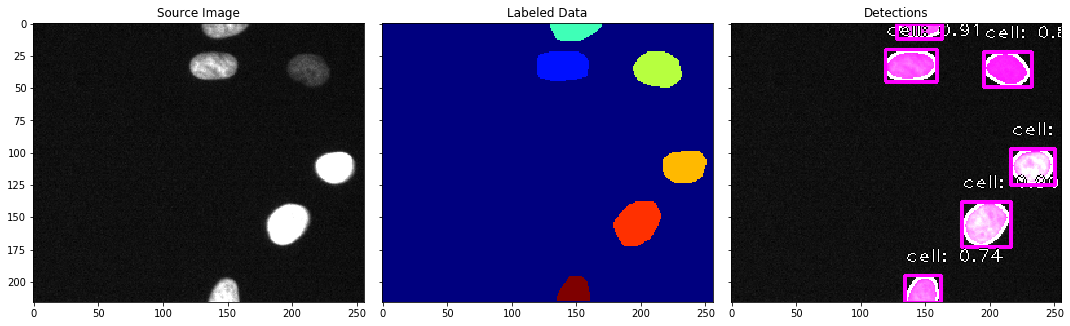

In [9]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from deepcell.utils.plot_utils import draw_detections, draw_masks


index = np.random.randint(low=0, high=X_test.shape[0])
print('Image Number:', index)

image, mask = X_test[index:index + 1], y_test[index:index + 1]

boxes, scores, labels, masks = prediction_model.predict(image)[-4:]

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

# copies to draw on
draw = image.copy()

# draw the masks
draw_masks(draw, boxes[0], scores[0], masks[0],
           score_threshold=0.5)

# draw the detections
draw_detections(draw, boxes[0], scores[0], labels[0],
                label_to_name=lambda x: 'cell',
                score_threshold=0.5,)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(mask, cmap='jet')
ax[1].set_title('Labeled Data')

ax[2].imshow(draw, cmap='jet')
ax[2].set_title('Detections')

fig.tight_layout()
plt.show()